<div style="font-family: 'Poppins'; font-weight: bold; letter-spacing: 0px; color: #FFFFFF; font-size: 300%; text-align: center; padding: 15px; background: #0A0F29; border: 8px solid #00FFFF; border-radius: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5);">
    XGBoost Classification Tutorial with Hyperparameter Tuning<br>
    Mental Health Dataset
</div>


# <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">📚 Table of Contents</div>

1. Introduction
1. Setup and Requirements
1. Data Loading and Exploration
1. Data Preprocessing
1. Baseline Model
1. Hyperparameter Tuning
1. Model Evaluation and Visualization
1. Feature Importance Analysis
1. Model Interpretation
1. Common Pitfalls and Best Practices

# <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Introduction</div>

## Understanding XGBoost  

XGBoost (eXtreme Gradient Boosting) is a powerful machine learning algorithm that excels with structured tabular data. Here's how it works:

## Basic Principle
XGBoost is a gradient boosting algorithm that works by building an ensemble of weak prediction models (typically decision trees) sequentially. Each new tree tries to correct the errors made by the previous trees.

## Tree Building Process

1. Starts with an initial prediction (typically the mean target value for regression or log-odds for classification).
2. For each new tree:
   - Calculates the residuals (differences between predictions and actual values).
   - Builds a decision tree to predict these residuals.
   - Adds the tree's predictions (multiplied by a learning rate) to the current predictions.

## Key Features

- **Regularization**: Controls model complexity using L1 (lasso) and L2 (ridge) regularization.
- **Tree Pruning**: Grows trees and starts pruning from the bottom-up.
- **Handling Missing Values**: Built-in support for sparse matrices and missing values.
- **Parallel Processing**: Efficient parallel tree building.

## Advantages

- High predictive accuracy.
- Handles non-linear relationships well.
- Built-in protection against overfitting.
- Automatically handles feature interactions.
- Can process both numerical and categorical features.

## See below links to great Statquest videos:

- [XGBoost Part 2 (of 4): Classification](https://www.youtube.com/watch?v=8b1JEDvenQU)
- [GBoost in Python from Start to Finish](https://www.youtube.com/watch?v=GrJP9FLV3FE)

## <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">What you'll learn</div>

- How to properly prepare data for XGBoost
- Understanding XGBoost's key parameters
- Implementing effective cross-validation strategies
- Visualizing and interpreting results
- Avoiding common pitfalls in gradient boosting

## <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Setup and Requirements</div> 

In [1]:
# Essential libraries
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualizations
blue_theme_palette = ["#1E90FF", "#0A0F29", "#87CEFA", "#00BFFF", "#4682B4", "#5F9EA0"]
sns.set(context='notebook', style='whitegrid')
sns.set_palette(sns.color_palette(blue_theme_palette))

TRIALS = 100
SEED = 42

In [2]:
def load_and_explore_data(file_path):
    """
    Load and perform initial data exploration.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file
        
    Returns:
    --------
    df : pandas.DataFrame
        Loaded dataframe
    """
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Basic data exploration
    print("Dataset Shape:", df.shape)
    
    # Display the first few rows
    print("\nDataset Head:")
    print(df.head())
    
    # Display basic statistics
    print("\nFeature Statistics:")
    print(df.describe().round(2))
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.any():
        print("\nMissing Values:")
        print(missing_values[missing_values > 0])
    
    # Display column information
    print("\nColumn Information:")
    print(df.info())
    
    # Plot target distribution
    if 'Depression' in df.columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(x='Depression', data=df)
        plt.title('Distribution of Depression Cases')
        plt.show()
    
    return df

def preprocess_data(df, test_size=0.2):
    """
    Preprocess data with proper handling of categorical and numerical features.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    test_size : float, default=0.2
        Test set proportion
        
    Returns:
    --------
    Preprocessed data matrices and arrays
    """
    # Create copy to avoid modifications to original data
    df = df.copy()
    
    # Drop unnecessary columns and separate features and target
    columns_to_drop = ['id', 'Name', 'Depression']
    X = df.drop(columns_to_drop, axis=1)
    y = df['Depression'].values
    
    # Identify numeric and categorical columns
    numeric_features = [
        'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
        'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
        'Financial Stress'
    ]
    
    categorical_features = [
        'Gender', 'City', 'Working Professional or Student',
        'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree',
        'Have you ever had suicidal thoughts ?',
        'Family History of Mental Illness'
    ]
    
    # Create preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    
    # Fit and transform the data
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    # Get feature names after transformation
    numeric_features_out = numeric_features
    cat_features_out = []
    for name in preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features):
        cat_features_out.append(name)
    feature_names = numeric_features_out + cat_features_out
    
    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train_transformed, label=y_train, feature_names=feature_names)
    dtest = xgb.DMatrix(X_test_transformed, label=y_test, feature_names=feature_names)
    
    return (dtrain, dtest, X_train_transformed, X_test_transformed, 
            y_train, y_test, feature_names)

def train_baseline_model(X_train, y_train, X_test, y_test):
    """Train a baseline XGBoost model with default parameters."""
    baseline_model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        early_stopping_rounds=10
    )
    
    baseline_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=50
    )
    
    return baseline_model

def tune_hyperparameters(X_train, y_train, trials=TRIALS, seed=SEED):
    """Perform random search for hyperparameter tuning."""
    param_distributions = {
        'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5]
    }
    
    model = xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=seed
    )
    
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        verbose=2,
        n_iter=trials,
        random_state=seed
    )
    
    random_search.fit(X_train, y_train)
    
    return random_search

def evaluate_model(model, X_test, y_test, title="Model Evaluation"):
    """Evaluate model performance with various metrics and plots."""
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Print classification report
    print(f"\n{title}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title('ROC Curve')
    plt.show()

def plot_feature_importance(model, feature_names):
    """Plot feature importance and return importance DataFrame."""
    importance = model.feature_importances_
    
    feat_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', 
                data=feat_importance.head(10), 
                palette=blue_theme_palette)
    plt.title('Top 10 Most Important Features')
    plt.show()
    
    return feat_importance

# Create SHAP plots for model interpretation
def create_shap_plots(model, X_train_transformed, X_test_transformed, feature_names):
    """
    Create various SHAP plots for model interpretation
    
    Parameters:
    model: Trained XGBoost model
    X_train_transformed: Training data
    X_test_transformed: Test data
    feature_names: List of feature names
    """
    # Initialize the SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values
    X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)
    
    # Get SHAP values based on model type
    if hasattr(model, 'predict_proba'):  # For classification
        shap_values = explainer.shap_values(X_test_df)
        if isinstance(shap_values, list):  # For binary classification
            shap_values_plot = shap_values[1]  # Use class 1 probabilities
        else:
            shap_values_plot = shap_values
    else:  # For regression
        shap_values_plot = explainer.shap_values(X_test_df)
    
    # 1. Summary Plot (Default)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_plot, X_test_df,
                     feature_names=feature_names,
                     show=False)
    plt.title("SHAP Summary Plot (Feature Importance)")
    plt.tight_layout()
    plt.show()
    
    # 2. Summary Bar Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_plot, X_test_df,
                     feature_names=feature_names,
                     plot_type="bar",
                     show=False)
    plt.title("SHAP Summary Bar Plot")
    plt.tight_layout()
    plt.show()
    
    # 3. Dependence Plots for top features
    feature_importance = np.abs(shap_values_plot).mean(0)
    top_features = np.argsort(feature_importance)[-3:]
    
    for feature_idx in top_features:
        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            feature_idx, 
            shap_values_plot, 
            X_test_df,
            feature_names=feature_names,
            show=False
        )
        plt.title(f"SHAP Dependence Plot for {feature_names[feature_idx]}")
        plt.tight_layout()
        plt.show()
    
    # 4. Force Plot for first prediction
    plt.figure(figsize=(20, 3))
    expected_value = explainer.expected_value
    if isinstance(expected_value, list):
        expected_value = expected_value[1]
        
    shap.force_plot(
        expected_value,
        shap_values_plot[0],
        X_test_df.iloc[0],
        feature_names=list(feature_names),
        matplotlib=True,
        show=False
    )
    plt.title("SHAP Force Plot for Single Prediction")
    plt.tight_layout()
    plt.show()
    
    # 5. Decision Plot
    plt.figure(figsize=(10, 8))
    shap.decision_plot(
        expected_value,
        shap_values_plot[:100],
        X_test_df.iloc[:100],
        feature_names=list(feature_names),
        show=False
    )
    plt.title("SHAP Decision Plot")
    plt.tight_layout()
    plt.show()
    
    # 6. Waterfall Plot for Single Instance
    plt.figure(figsize=(10, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_plot[0],
            base_values=expected_value,
            data=X_test_df.iloc[0].values,
            feature_names=list(feature_names)
        ),
        show=False
    )
    plt.title("SHAP Waterfall Plot for Single Instance")
    plt.tight_layout()
    plt.show()

def analyze_feature_interactions(model, X_test_transformed, feature_names, top_n=5):
    """
    Analyze and visualize feature interactions for the top n most important features
    """
    explainer = shap.TreeExplainer(model)
    X_test_df = pd.DataFrame(X_test_transformed, columns=feature_names)
    
    # Get SHAP values for classification or regression
    if hasattr(model, 'predict_proba'):
        shap_values = explainer.shap_values(X_test_df)
        if isinstance(shap_values, list):
            shap_values = shap_values[1]
    else:
        shap_values = explainer.shap_values(X_test_df)
    
    # Get top n important features
    feature_importance = np.abs(shap_values).mean(0)
    top_features_idx = np.argsort(feature_importance)[-top_n:]
    top_features = [feature_names[i] for i in top_features_idx]
    
    # Create interaction matrix for top features
    interaction_matrix = np.zeros((top_n, top_n))
    
    # Calculate interaction values
    for i, feat1 in enumerate(top_features_idx):
        for j, feat2 in enumerate(top_features_idx):
            if i <= j:
                interaction = np.corrcoef(shap_values[:, feat1], shap_values[:, feat2])[0,1]
                interaction_matrix[i, j] = interaction
                interaction_matrix[j, i] = interaction
    
    # Visualize interaction matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(interaction_matrix, 
                annot=True, 
                fmt='.2f', 
                cmap='RdBu', 
                center=0,
                xticklabels=top_features,
                yticklabels=top_features)
    plt.title('Feature Interaction Strength Matrix')
    plt.tight_layout()
    plt.show()
    
    return interaction_matrix, top_features

# <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Data Loading and Exploration</div>

Dataset Shape: (140700, 20)

Dataset Head:
   id      Name  Gender   Age           City Working Professional or Student  \
0   0  Aaradhya  Female  49.0       Ludhiana            Working Professional   
1   1     Vivan    Male  26.0       Varanasi            Working Professional   
2   2    Yuvraj    Male  33.0  Visakhapatnam                         Student   
3   3    Yuvraj    Male  22.0         Mumbai            Working Professional   
4   4      Rhea  Female  30.0         Kanpur            Working Professional   

         Profession  Academic Pressure  Work Pressure  CGPA  \
0              Chef                NaN            5.0   NaN   
1           Teacher                NaN            4.0   NaN   
2               NaN                5.0            NaN  8.97   
3           Teacher                NaN            5.0   NaN   
4  Business Analyst                NaN            1.0   NaN   

   Study Satisfaction  Job Satisfaction     Sleep Duration Dietary Habits  \
0                 Na

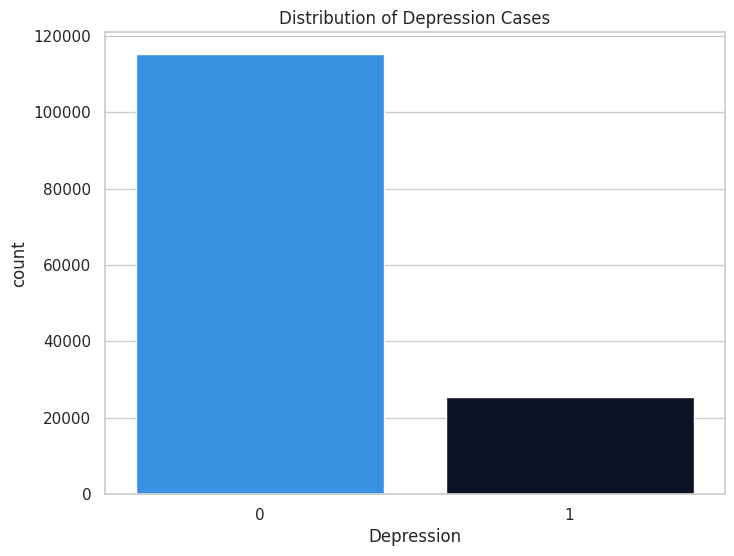

In [3]:
# Load dataset

file_path = '/kaggle/input/playground-series-s4e11/train.csv'
df = load_and_explore_data(file_path)

# <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Data Preprocessing</div>

In [4]:
dtrain, dtest, X_train_transformed, X_test_transformed, y_train, y_test, feature_names = preprocess_data(df)

Found unknown categories in columns [1, 3, 4, 5, 6] during transform. These unknown categories will be encoded as all zeros


# <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Baseline Model</div>

In [5]:
# Train baseline model
print("\nTraining baseline model...")
baseline_model = train_baseline_model(
    X_train_transformed, y_train,
    X_test_transformed, y_test
)


Training baseline model...
[0]	validation_0-logloss:0.43155
[50]	validation_0-logloss:0.16862
[99]	validation_0-logloss:0.15690



Baseline Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23027
           1       0.84      0.81      0.82      5113

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.89     28140
weighted avg       0.94      0.94      0.94     28140



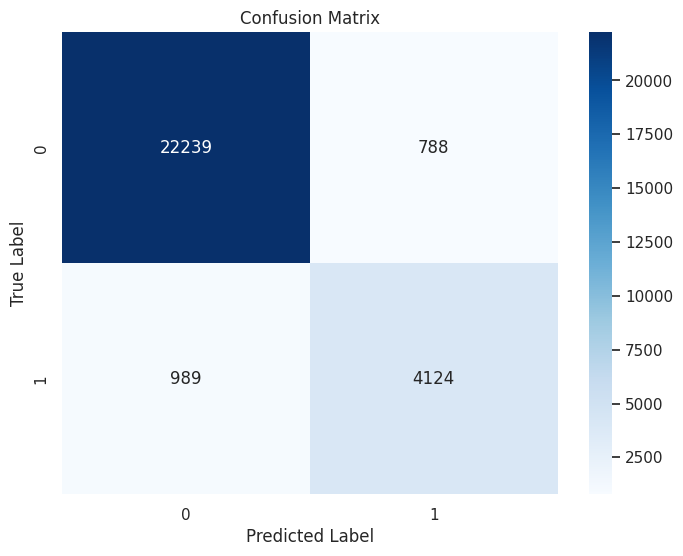

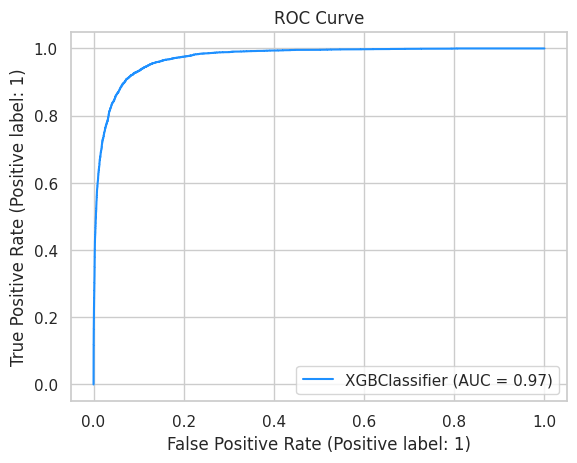

In [6]:
# Evaluate baseline model
evaluate_model(baseline_model, X_test_transformed, y_test,
              title="Baseline Model Evaluation")

# <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Hyperparameter Tuning</div>


## Core Parameters

### n_estimators
- Number of boosting rounds (trees)
- **Default**: 100
- Higher values may improve performance but increase training time
- **Tips**: Start with 100 and increase if model underfits

### max_depth
- Maximum depth of each tree
- **Default**: 6
- Controls model complexity
- **Tips**: Range 3-10; lower values prevent overfitting

### learning_rate (eta)
- Step size shrinkage
- **Default**: 0.3
- Controls impact of each tree
- **Tips**: Lower values (0.01-0.1) require more trees but often giv
- Higher rates risk overfitting by allowing trees to make strong corrections
- Lower rates create more robust models by allowing gradual, stable learninge better performance

## Sampling Parameters

### subsample
- Fraction of samples used for training each tree
- **Default**: 1.0
- **Range**: (0, 1]
- **Tips**: Values < 1 help prevent overfitting

### colsample_bytree
- Fraction of features used for training each tree
- **Default**: 1.0
- **Range**: (0, 1]
- **Tips**: Useful for high-dimensional data

## Regularization Parameters

### min_child_weight
- Minimum sum of instance weights needed in a child
- **Default**: 1
- Higher values prevent overfitting
- **Tips**: Increase if model is overfitting

### gamma (min_split_loss)
- Minimum loss reduction for split
- **Default**: 0
- **Tips**: Increase for conservative splitting

### alpha (L1 regularization)
- L1 regularization on weights
- **Default**: 0
- **Tips**: Useful for sparse data

### lambda (L2 regularization)
- L2 regularization on weights
- **Default**: 1
- **Tips**: Increase to make model more conservative

## Performance Parameters

### n_jobs
- Number of parallel threads
- **Default**: -1 (all cores)
- **Tips**: Use -1 for maximum parallelization

### random_state
- Random seed
- **Tips**: Set for reproducibility

In [7]:
# Tune hyperparameters
print("\nTuning hyperparameters...")
random_search = tune_hyperparameters(X_train_transformed, y_train)
print("\nBest parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)


Tuning hyperparameters...
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=6, min_child_weight=3, n_estimators=600, subsample=0.9; total time=  51.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, min_child_weight=3, n_estimators=1000, subsample=0.8; total time= 1.3min
[CV] END colsample_bytree=0.9, learning_rate=0.05, max_depth=5, min_child_weight=3, n_estimators=100, subsample=1.0; total time=  12.5s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=300, subsample=0.9; total time=  38.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, min_child_weight=1, n_estimators=700, subsample=0.9; total time=  49.4s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=700, subsample=1.0; total time=  45.5s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=

# <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Model Evaluation and Visualization </div>


Tuned Model Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     23027
           1       0.84      0.82      0.83      5113

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.90     28140
weighted avg       0.94      0.94      0.94     28140



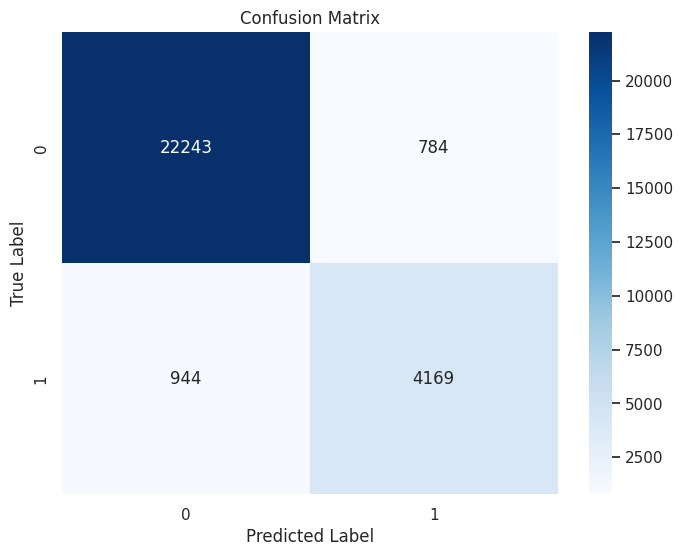

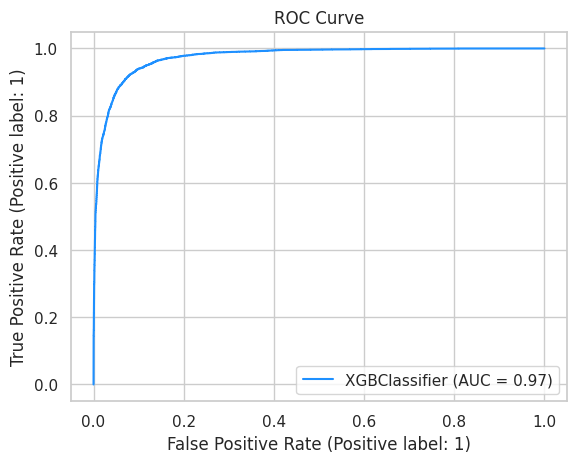

In [8]:
best_model = random_search.best_estimator_
evaluate_model(best_model, X_test_transformed, y_test,
          title="Tuned Model Evaluation")

# <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Feature Importance Analysis</div>

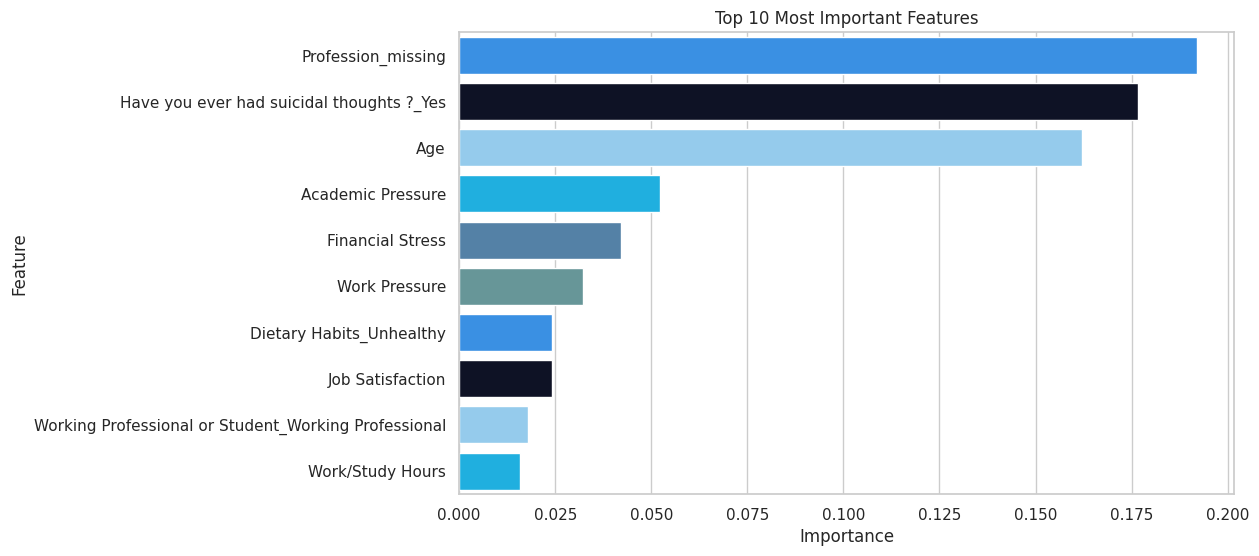

In [9]:
feat_importance = plot_feature_importance(best_model, feature_names)

# <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Model Interpretation</div>


Creating SHAP plots...


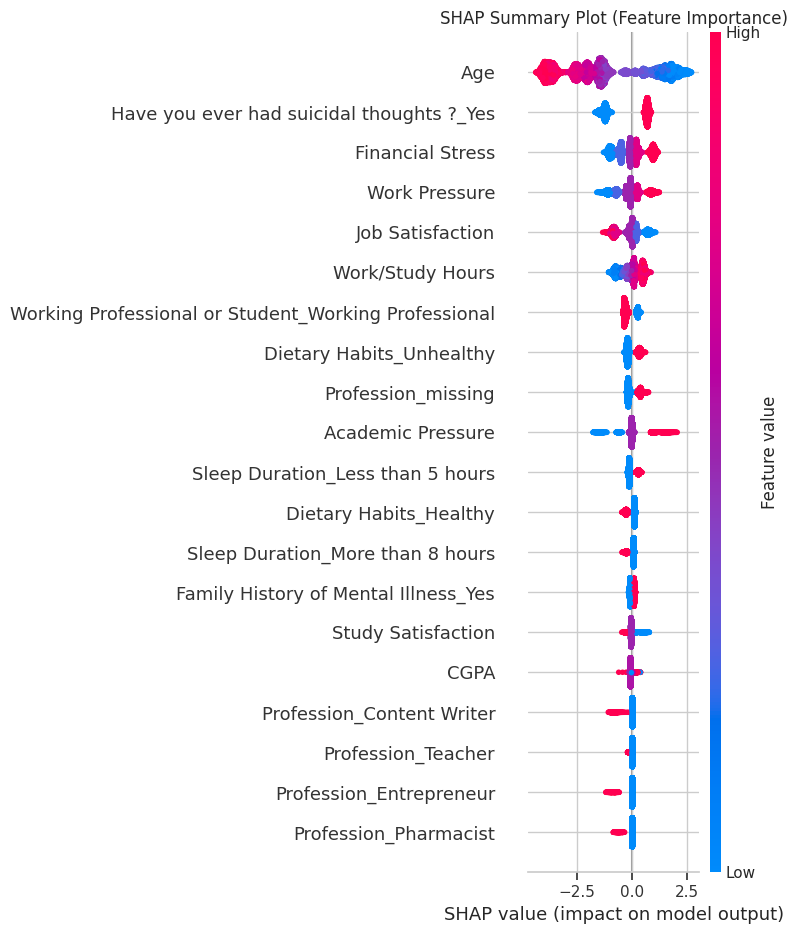

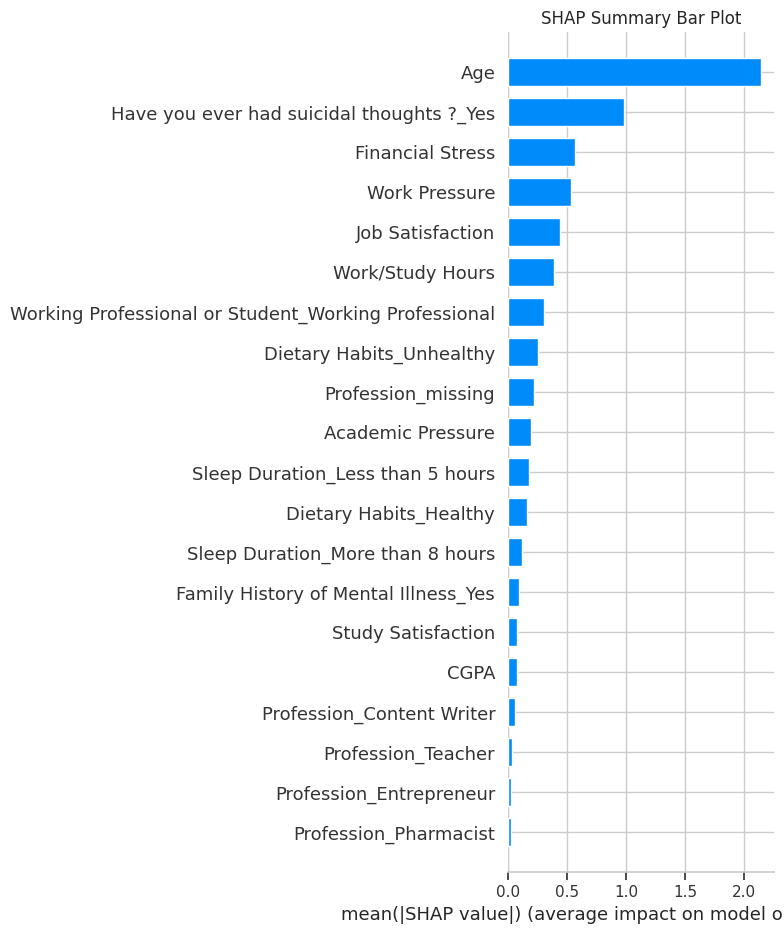

<Figure size 1000x600 with 0 Axes>

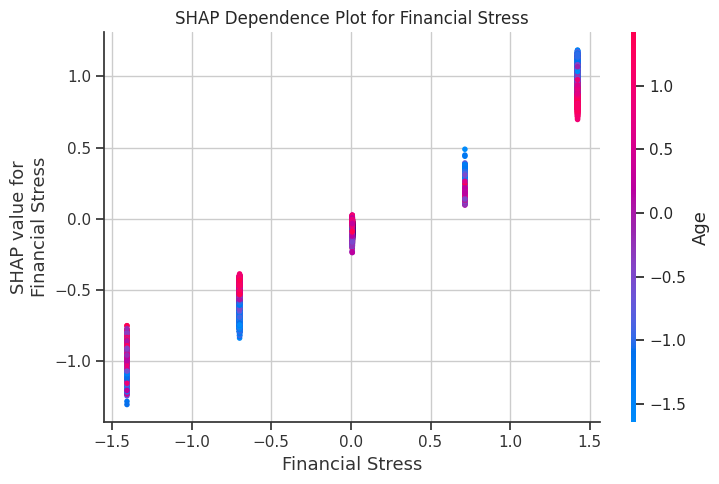

<Figure size 1000x600 with 0 Axes>

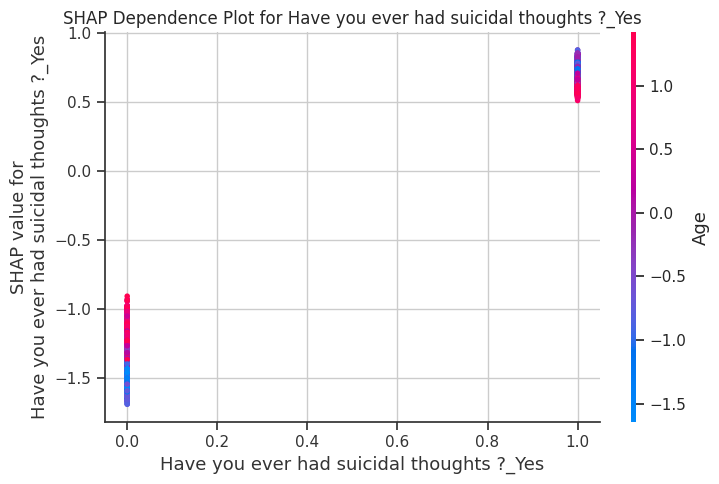

<Figure size 1000x600 with 0 Axes>

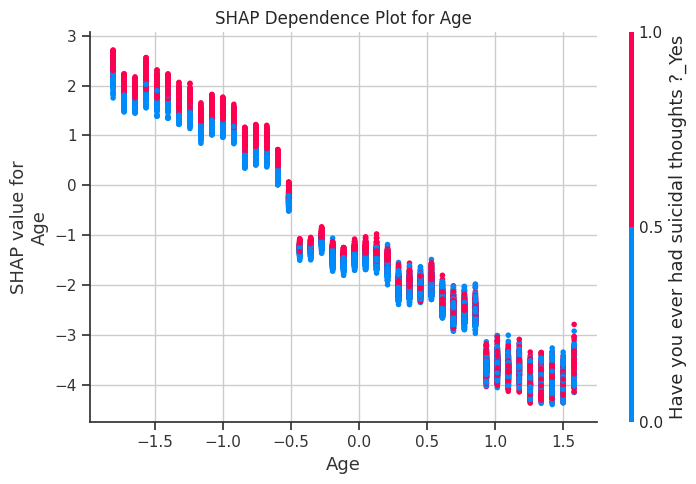

<Figure size 2000x300 with 0 Axes>

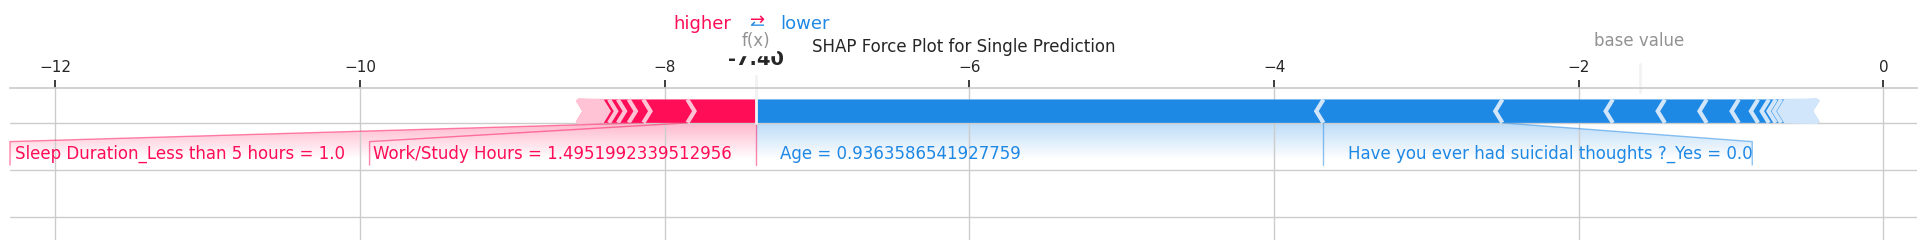

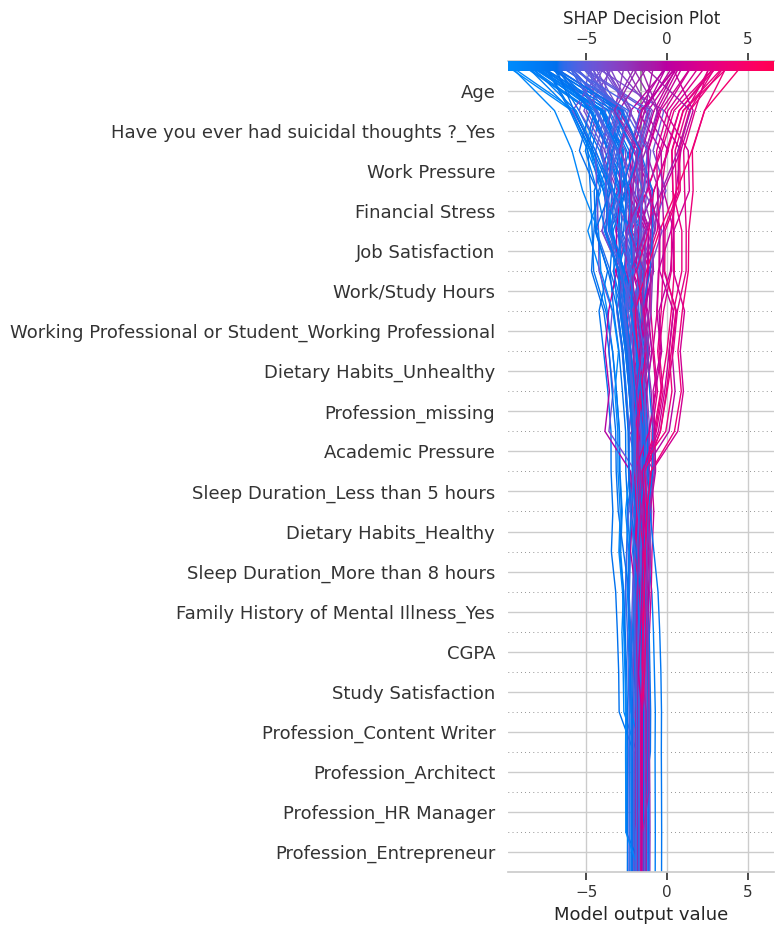

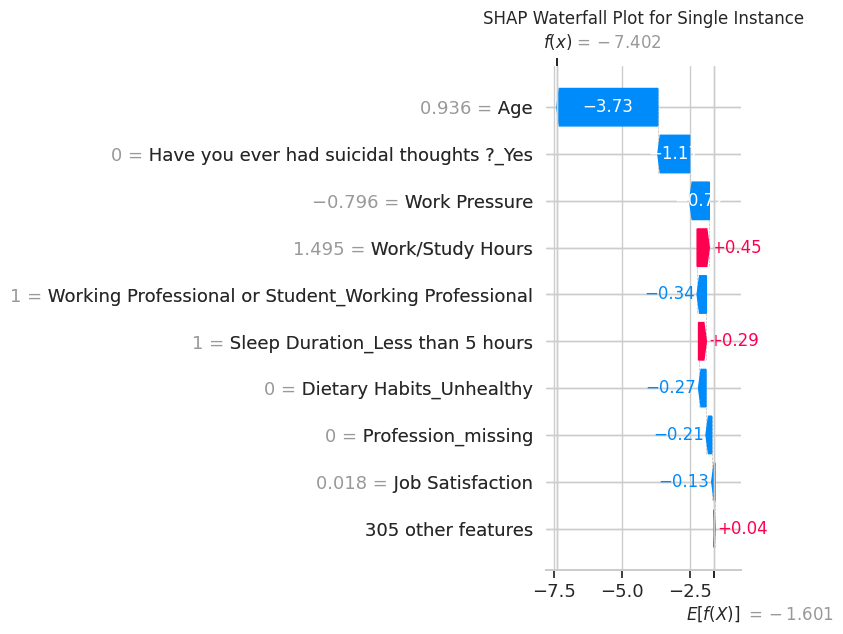


Analyzing feature interactions...


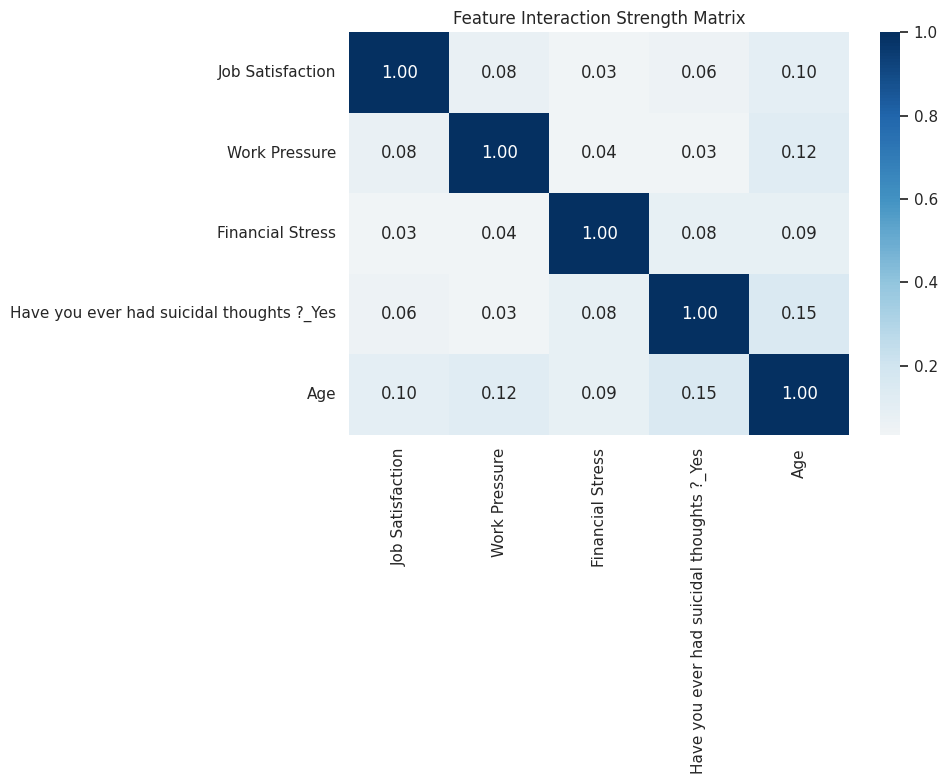

In [10]:
# Create the plots and analyze interactions
print("\nCreating SHAP plots...")
create_shap_plots(best_model, X_train_transformed, X_test_transformed, feature_names)

print("\nAnalyzing feature interactions...")
interaction_matrix, top_features = analyze_feature_interactions(
    best_model, 
    X_test_transformed, 
    feature_names
)

# <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Common Pitfalls and Best Practices</div>

## <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">🚫 Common Pitfalls to Avoid</div>

1. Data Leakage: Always scale features after train-test split
2. Overfitting: Watch out for:
    - Too many trees (high n_estimators)
    - Deep trees (high max_depth)
    - Learning rate too high
3. Class Imbalance: Use `scale_pos_weight` parameter
4. Memory Issues: Use DMatrix for large datasets

## <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">✅ Best Practices:</div>

1. Early Stopping: Always use early_stopping_rounds
2. Cross-Validation: Use stratified k-fold for imbalanced datasets
3. Feature Engineering: Consider:
    - Handling missing values
    - Creating interaction features
    - Proper encoding of categorical variables
4. Parameter Tuning: Start with:
    - Lower learning rate (0.01-0.1)
    - Reasonable max_depth (3-6)
    - Moderate n_estimators (100-1000)

## <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:100%; text-align:center; border: 2px solid #0A0F29; border-radius:10px; padding: 10px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Final Tips</div>

- Monitor training vs validation metrics
- Use SHAP values for model interpretation
- Consider ensemble methods for better performance
- Document your preprocessing steps and parameters

This tutorial covered the essential aspects of building and tuning an XGBoost classifier. For more advanced topics, consider exploring:
- Custom evaluation metrics
- Advanced feature engineering
- Handling imbalanced datasets
- BaseException models in production

# <div style="background-color:#0A0F29; font-family:'Poppins',; color:#E0F7FA; font-size:140%; text-align:center; border: 2px solid #00FFFF; border-radius:15px; padding: 15px; box-shadow: 5px 5px 20px rgba(0, 0, 0, 0.5); font-weight: bold; letter-spacing: 1px; text-transform: uppercase;">Further reading</div>

- [XGBoost Documentation](https://xgboost.readthedocs.io/en/latest/index.html)
- [XGBoost: A Scalable Tree Boosting System by Tianqi Chen and Carlos Guestrin]()
- [XGBoost With Python by Jason Brownlee](https://machinelearningmastery.com/xgboost-with-python/)
- [Effective XGBoost by Matt Harrison](https://www.amazon.com/Effective-XGBoost-Optimizing-Understanding-Classification/dp/1792310390)
  [Hands-On Gradient Boosting with XGBoost and scikit-learn by Corey Wade](https://www.oreilly.com/library/view/hands-on-gradient-boosting/9781839218354/)